In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D

import numpy as np
import scipy.stats as st
from sklearn import decomposition
from sklearn import preprocessing
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn import manifold
from sklearn import metrics
from datetime import datetime
import timeit
import matplotlib.cm as cm
from time import time
import statistics
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator
from scipy.spatial.distance import cdist
from datetime import date


pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 1000)

Fonction de traitement automatique des imports

In [7]:
def import_nettoyage_automatique(date_filtre):

    # import des fichiers
    df_olist_customers_dataset = pd.read_csv(
        'olist_customers_dataset.csv', delimiter=',')
    df_olist_order_items_dataset = pd.read_csv(
        'olist_order_items_dataset.csv', delimiter=',')
    df_olist_order_reviews_dataset = pd.read_csv(
        'olist_order_reviews_dataset.csv', delimiter=',')
    df_olist_orders_dataset = pd.read_csv(
        'olist_orders_dataset.csv', delimiter=',')

    # Conversion de 'order_purchase_timestamp' en datetime
    df_olist_orders_dataset['order_purchase_timestamp'] = pd.to_datetime(
        df_olist_orders_dataset['order_purchase_timestamp'])

    # Conversion de 'date_filtre' en datetime
    date_filtre = pd.to_datetime(date_filtre)

    # Filtre pour ne conserver que les commandes égale ou antérieures à 'date_filtre'
    df_olist_orders_dataset = df_olist_orders_dataset[
        df_olist_orders_dataset['order_purchase_timestamp'] <= date_filtre]

    # Jointure des fichiers clients et commandes
    df_olist_custumer = df_olist_customers_dataset[['customer_id', 'customer_unique_id']].merge(
        df_olist_orders_dataset[['order_id', 'customer_id', 'order_purchase_timestamp']], left_on='customer_id', right_on='customer_id')

    # Jointure des fichiers clients et review
    df_olist_custumer = df_olist_custumer.merge(df_olist_order_reviews_dataset[[
                                                'order_id', 'review_score']], left_on='order_id', right_on='order_id')

    # Jointure des fichiers clients et détails des commandes
    df_olist_custumer = df_olist_custumer.merge(df_olist_order_items_dataset[[
                                                'order_id', 'price']], left_on='order_id', right_on='order_id')

    # Suppression des clefs de jointure inutiles
    df_olist_custumer = df_olist_custumer.drop(
        ['order_id', 'customer_id'], axis=1)

    # Tri du fichier créé par customer_unique_id et par date croissante
    df_olist_custumer_V2 = df_olist_custumer.sort_values(
        by=['customer_unique_id', 'order_purchase_timestamp'], ascending=True).copy()

    # Création du fichier consolidé par client

    # Création d'un dataset avec 'customer_unique_id','order_purchase_timestamp','review_score' sans doublons sur 'customer_unique_id' en gardant le dernier enregistrement
    df_part_1 = df_olist_custumer_V2[['customer_unique_id', 'order_purchase_timestamp',
                                      'review_score']].drop_duplicates(subset='customer_unique_id', keep='last')

    # Création d'un dataset groupé sur 'customer_unique_id' en sommant 'price'
    df_part_2 = df_olist_custumer_V2[['customer_unique_id', 'price']].groupby(
        'customer_unique_id').sum()

    # Création d'un dataset groupé sur 'customer_unique_id' en comptant 'customer_unique_id'
    df_part_3 = df_olist_custumer_V2[[
        'customer_unique_id', 'order_purchase_timestamp']].groupby('customer_unique_id').count()
    df_part_3['frequence'] = df_part_3['order_purchase_timestamp']
    df_part_3 = df_part_3[['frequence']]

    # Fusion des 3 datasets créés
    df_olist_custumer_V3 = pd.merge(
        df_part_1, df_part_2, on='customer_unique_id')
    df_olist_custumer_V3 = pd.merge(
        df_olist_custumer_V3, df_part_3, on='customer_unique_id')

    # Conversion de la date de dernière command en nombres de jours depuis la première commande enregistrée
    date_reference = min(pd.to_datetime(
        df_olist_orders_dataset['order_purchase_timestamp']))
    df_olist_custumer_V3['order_purchase_timestamp'] = (
        df_olist_custumer_V3['order_purchase_timestamp']-date_reference)/np.timedelta64(1, 'D')

    # Retrait des clients dont la dernière commande est trop ancinne (<100)
    df_olist_custumer_V3 = df_olist_custumer_V3[df_olist_custumer_V3['order_purchase_timestamp'] > 100].copy(
    )

    # Retrait des commandes dont le montant des commandes est supérieur à 1000
    df_olist_custumer_V3 = df_olist_custumer_V3[df_olist_custumer_V3['price'] <= 1000]

    return df_olist_custumer_V3

Navigation vers le dossier source

In [8]:
cd Desktop/Formation_Ingenieur_Machine_Learning/P4_voelker_jean-florent

[Errno 2] No such file or directory: 'Desktop/Formation_Ingenieur_Machine_Learning/P4_voelker_jean-florent'
/Users/jfv/Desktop/Formation_Ingenieur_Machine_Learning/P4_voelker_jean-florent


Chargement du fichier issu du nettoyage des données

In [9]:
df_olist_customers_dataset = import_nettoyage_automatique(date.today())

In [10]:
data_complet_df = df_olist_customers_dataset[['price', 'frequence', 'order_purchase_timestamp']]

Je réduis la taille du dataset à 5000 avec un Kmeans.

In [105]:
n_clusters_init = 5000
km_init = KMeans(n_clusters=n_clusters_init)
km_init.fit(data_complet_df)
data_reduced = km_init.cluster_centers_
data_reduced_df = pd.DataFrame(data_reduced, columns=data_complet_df.columns)

D'après les résultats du clustering c'est un clustering par Kmeans sur une projection Isomap avec n_neighbors=22 qui donne le meilleur résultat.

In [106]:
# Je paramètre le nombre de composante à 2
n_components = 2
# Je paramètre le n_neighbors sur 24
Isomap_n_neighbors = 24

# Je créé le model de réduction de dimension
Isomap = manifold.Isomap(n_neighbors=Isomap_n_neighbors,
                         n_components=n_components, n_jobs=-1)

J'extrait la date de la dernière commande présente dans le fichier des commandes

In [107]:
date_finale = max(data_reduced_df['order_purchase_timestamp'])

Pour faire ma recherche d'intervalle de mise à jour, je vais créer un dataset T0 sans les données des 6 derniers mois que j'approxime à 180j (6x30).

In [108]:
periode_de_recherche = 180
data_Model_0_df = data_reduced_df[data_reduced_df['order_purchase_timestamp'] <= (
    date_finale-periode_de_recherche)]

Je centre et réduis les données data_Model_0.

In [109]:
data_Model_0 = data_Model_0_df.values
std_scale_M_0 = preprocessing.StandardScaler().fit(data_Model_0)
data_Model_0_scaled = std_scale_M_0.transform(data_Model_0)

#Je projete les données standardisées selon la réduction de dimension  Isomap

In [110]:
data_Model_0_scaled_projected = Isomap.fit_transform(data_Model_0_scaled)

J'entraîne un clustering Kmeans sur les données data_Model_0_scaled_projected

In [111]:
Model_0 = KMeans(n_clusters=3)
Model_0.fit(data_Model_0_scaled_projected)

KMeans(n_clusters=3)

Je vais calculer le clustering sur des données augmentées à intervalle de 7jours sur une période de 180jours en utilisant le Model_0 et le Model_i transfomé et fité sur les données disponibles à Ti. Pour chacun des couples de clusterings obtenus (Clustering_M_0 vs Clustering_M_i), je calcule l'Adjusted Rand Index.

In [112]:
# Initialisation des variables
intervalle = 7
nb_iterations = int(periode_de_recherche/intervalle)

# Initialisation des dictionnaires pour le calcul de l'ARI
ARI_T_i = []
nb_jours = []

# Boucle qui parcours la période de 6 mois selon nb_iterations
for iteration in np.arange(0, nb_iterations+1):
    # Calcul du datdaset à T_i
    data_Model_T_i_df = data_reduced_df[data_reduced_df['order_purchase_timestamp'] <= (
        date_finale-(periode_de_recherche-iteration*intervalle))]
    data_Model_T_i = data_Model_T_i_df.values

    # Standardisation des données à T_i selon Model_0
    data_Model_T_i_M_0_scaled = std_scale_M_0.transform(data_Model_T_i)

    # Projection Isomap des données à T_i standardisée selon std_scale_M_0
    data_Model_T_i_M_0_scaled_projected = Isomap.fit_transform(
        data_Model_T_i_M_0_scaled)

    # Calcul du clustering selon le Model_0 sur les données à T_i
    Clustering_Model_O_T_i = Model_0.predict(
        data_Model_T_i_M_0_scaled_projected)

    # Standardisation des données à T_i selon Model_i
    std_scale_T_i = preprocessing.StandardScaler().fit(data_Model_T_i)
    data_Model_T_i_M_i_scaled = std_scale_T_i.transform(data_Model_T_i)

    # Projection Isomap des données à T_i standardisée selon std_scale_T_i
    data_Model_T_i_M_i_scaled_projected = Isomap.fit_transform(
        data_Model_T_i_M_i_scaled)

    # Calcul du clustering selon le Model_T_i sur les données à T_i
    Model_i = KMeans(n_clusters=4)
    Model_i.fit(data_Model_T_i_M_i_scaled_projected)
    Clustering_Model_i_T_i = Model_i.labels_

    # Calcul de l'ARI
    nb_jours.append(iteration*intervalle)
    ARI_T_i.append(metrics.adjusted_rand_score(
        Clustering_Model_O_T_i, Clustering_Model_i_T_i))

Je récupère la durée en jours pendant laquelle l'ARI est supérieur à 0.8

In [113]:
filtered_ARI = list(filter(lambda ARI: ARI >= 0.8, ARI_T_i))
jour_MAJ = nb_jours[len(filtered_ARI)-1]

Je graphe les scores ARI obtenus à chaque itération

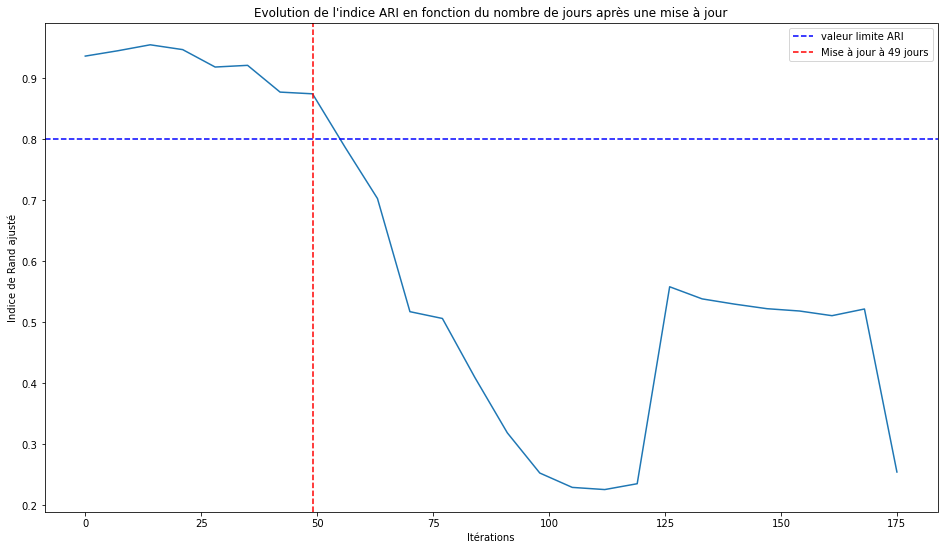

In [114]:
plt.figure(figsize=(16, 9))
plt.plot(nb_jours, ARI_T_i)
plt.axhline(y=0.8, color="blue", linestyle="--", label='valeur limite ARI')
plt.axvline(x=jour_MAJ, color="red", linestyle="--",
            label='Mise à jour à {0} jours'.format(jour_MAJ))
plt.xlabel("Itérations")
plt.ylabel("Indice de Rand ajusté")
plt.title(
    "Evolution de l'indice ARI en fonction du nombre de jours après une mise à jour")

plt.legend(loc="upper right")
plt.show()

La segmentation client est à réaliser tous les 49 jours (7 semaines).

Je recommence la simulation en ajustant ma période de recherche.

In [115]:
periode_de_recherche = jour_MAJ
data_Model_0_FS_df = data_reduced_df[data_reduced_df['order_purchase_timestamp'] < (
    date_finale-periode_de_recherche)]

Je centre et réduis les données data_Model_0.

In [116]:
data_Model_0_FS = data_Model_0_FS_df.values
std_scale_M_0_FS = preprocessing.StandardScaler().fit(data_Model_0_FS)
data_Model_0_FS_scaled = std_scale_M_0_FS.transform(data_Model_0_FS)

#Je projete les données standardisées selon la réduction de dimension  Isomap

In [117]:
data_Model_0_FS_scaled_projected = Isomap.fit_transform(data_Model_0_FS_scaled)

J'entraîne un clustering Kmeans sur les données data_Model_0_scaled_projected

In [118]:
Model_0_FS = KMeans(n_clusters=4)
Model_0_FS.fit(data_Model_0_FS_scaled_projected)

KMeans(n_clusters=4)

Je vais calculer le clustering sur des données augmentées à intervalle de 7jours sur une période de jour_MAJ jours en utilisant le Model_0 et le Model_i transfomé et fité sur les données disponibles à Ti. Pour chacun des couples de clusterings obtenus (Clustering_M_0 vs Clustering_M_i), je calcule l'Adjusted Rand Index.

In [119]:
# Initialisation des variables
intervalle = 7
nb_iterations = int(jour_MAJ/intervalle)
periode_de_recherche = jour_MAJ

# Initialisation des dictionnaires pour le calcul de l'ARI
ARI_T_i = []
nb_jours = []

# Boucle qui parcours la période de 6 mois selon nb_iterations
for iteration in np.arange(0, nb_iterations+1):
    # Calcul du datdaset à T_i
    data_Model_T_i_df = data_reduced_df[data_reduced_df['order_purchase_timestamp'] < (
        date_finale-(periode_de_recherche-iteration*intervalle))]
    data_Model_T_i = data_Model_T_i_df.values

    # Standardisation des données à T_i selon Model_0
    data_Model_T_i_M_0_scaled = std_scale_M_0_FS.transform(data_Model_T_i)

    # Projection Isomap des données à T_i standardisée selon std_scale_M_0
    data_Model_T_i_M_0_scaled_projected = Isomap.fit_transform(
        data_Model_T_i_M_0_scaled)

    # Standardisation des données à T_i selon Model_i
    std_scale_T_i = preprocessing.StandardScaler().fit(data_Model_T_i)
    data_Model_T_i_M_i_scaled = std_scale_T_i.transform(data_Model_T_i)

    # Projection Isomap des données à T_i standardisée selon std_scale_T_i
    data_Model_T_i_M_i_scaled_projected = Isomap.fit_transform(
        data_Model_T_i_M_i_scaled)

    # Calcul du clustering selon le Model_0 sur les données à T_i
    Clustering_Model_O_T_i = Model_0_FS.predict(
        data_Model_T_i_M_0_scaled_projected)

    # Calcul du clustering selon le Model_T_i sur les données à T_i
    Model_i = KMeans(n_clusters=4)
    Model_i.fit(data_Model_T_i_M_i_scaled_projected)
    Clustering_Model_i_T_i = Model_i.labels_

    # Calcul de l'ARI
    nb_jours.append(iteration*intervalle)
    ARI_T_i.append(metrics.adjusted_rand_score(
        Clustering_Model_O_T_i, Clustering_Model_i_T_i))

Je récupère la durée en jours pendant laquelle l'ARI est supérieur à 0.8

In [120]:
filtered_ARI_FS = list(filter(lambda ARI: ARI >= 0.8, ARI_T_i))
jour_MAJ_FS = nb_jours[len(filtered_ARI_FS)-1]

Je graphe les scores ARI obtenus à chaque itération

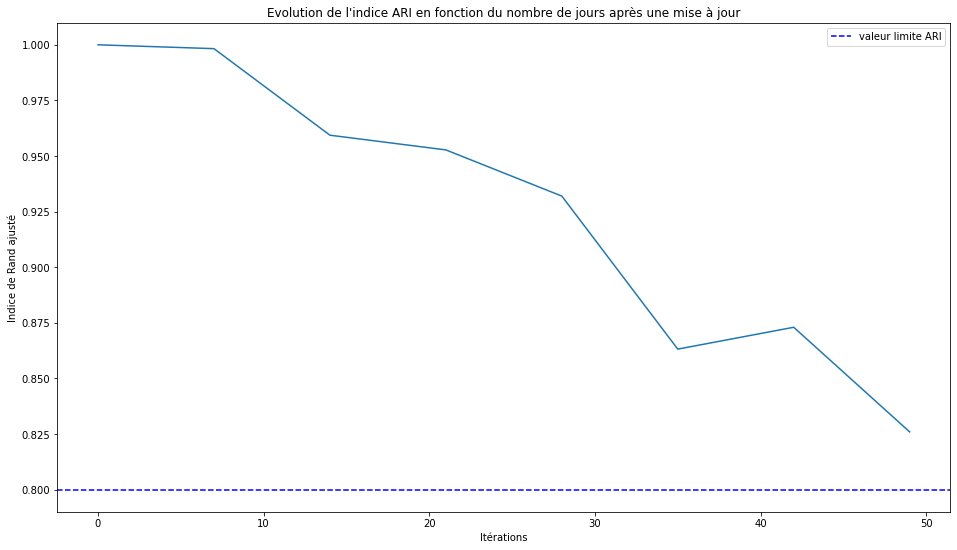

In [121]:
plt.figure(figsize=(16, 9))
plt.plot(nb_jours, ARI_T_i)
plt.axhline(y=0.8, color="blue", linestyle="--", label='valeur limite ARI')
plt.xlabel("Itérations")
plt.ylabel("Indice de Rand ajusté")
plt.title(
    "Evolution de l'indice ARI en fonction du nombre de jours après une mise à jour")

plt.legend(loc="upper right")
plt.show()

Le graphique ci-dessus montre que l'ARI demeure juste au-dessus de 0.8 au bout de 70 jours.